# Stock Price Prediction Based On Past Prices
## Project Proposal

Project by:  

Asaf Alina  
Alon Gouldman




# Goal

Our goal is to predict stocks' future prices, using historical prices data.  
But not stock prices alone would be interesting to forecast;  
prediction of stock's volatility, or future direction (up/down) - would be interesting, and might yeild profits.


Ideally, we would want to be able to predict stocks's prices, and beat the ultimate benchmark - the market itself.  
That being said, beating the market isnt neccessrily indicate of good strategy, as there might be other strategies that beat our strategy.  
Therefore, assuming we do manage to beat the market, we would make a comparison between our model/s, and other models/trading strategies.

# Motivation

The motivation behind being able to predict the prices of the stock market is clear -  
knowing if price of a stock would go up, would allow us as investors to trade the stocks and earn profits.  

This simple goal is, in fact, one of the toughest problems in history.  
Great minds and a lot of money was spilled trying to solve this problem -  
since this ability to forecast prices means a great financial benefit for the one who acquire it.  

The equty market is a zero-sum game - one's gains is another's losses.  
Therefore, market participents has no interest of sharing knowledge,  
as once someone does, the knowledge will be "priced" in the market, and the edge will be lost. 

The dynamic nature of the stock market - the changing correlations and non-linearity -  
make some researches believe in the "randon walk theory" - which state that stock prices move randomly.  
Even if the stock market is not totally random, it is affected by many factors, such as global
economy, politics, investor expectation, etc -  
which make future movements very hard to forecast.


That being said - we try our luck in solving this problem. We believe we have a chance to success, because of these factors: 
1. The data about the stocks is out there - but turns out it is not so easy to put your hands on good quality data after all.  
We had a hard time getting big amount of data (more on that later),  
so we think that when raising the entry barrier up - we face less competitors. 
2. We assume that even if the data looks random - it is not random at all.  
The price of a stock is an aggregated mix of what every investor in the world is pricing that stock in that moment.  
Humans are not so rational - but they do not act randomly. And so, it make sense to us that there could be a way to predict the way people will behave.

# Our Data
A simple Google search usually solve most of the problems in life.  
Not in this case though - going through a lot of websites and search results, we could not find a good source of data to test our models against. The data we were looking for is called "intraday" data - we wanted to know everything that happened on every minute in the stock market. 

finding daily data was relativly easy - but out goal was to be able to predict the stock market in every minute, and this data was more of a challenge. 

We almost lost hope - but eventually we managed to find two interesting sources of data. 

## IEX stock market data
[IEX website](https://iextrading.com/) has an almost free API about stocks' prices. There is a limit to the number of history we could get - and we could get only partuall data about the stocks. But the advantage of this website is that there is data about ~8700 stocks, so it was a great source of data for us. 

### scraping
We build a web scraper with [Scrapy](https://scrapy.org/), in order to get all the stocks data, and saving it into different files, based on the stock ticker. We managed to get data of around a year back - from the 1/4/19 to the 06/05/2020. We got a total of 8,737 stocks, data that weights 35.03 GB. 

<img src="dir.jpg" alt="drawing" width="200"/>

### The Data

Lets get a glimps of our data. We will see the data for a single stock looks like. We will choose a single ticker - Apple inc's stock - AAPL. 

In [1]:
from pathlib import Path
from typing import Optional
import pandas as pd


def minimal_IEX_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    """ get raw IEX-OHLC dataframe, make minimal preprocessing on it and remove redundant columns """

    # make 1 datetime column
    df['datetime'] = df['date'] + "," + df['minute']
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d,%H:%M')
    del df['date']
    del df['minute']
    del df['label']

    # sort data by from old datetime to new datetime
    df.sort_values(by=['datetime']).reset_index(drop=True, inplace=True)

    return df


def get_stock_data(ticker: str) -> Optional[pd.DataFrame]:
    optional_file_paths = ['data/relevant/snp500_from_iex', 'data/relevant/iex_data']
    for path in optional_file_paths:
        file_path = Path(path) / f"{ticker}.csv"
        if file_path.exists():
            return pd.read_csv(file_path)
    return None


apple_data = get_stock_data("AAPL")
minimal_IEX_preprocessing(apple_data)
apple_data.head()

,high,low,open,close,average,volume,notional,numberOfTrades,datetime
0,200.385,199.69,200.33,200.320,200.100,20793.0,4160671.710,131.0,2019-04-09 09:30:00
1,200.880,200.33,200.48,200.690,200.643,17520.0,3515273.345,139.0,2019-04-09 09:31:00
2,201.090,200.59,200.72,200.870,200.794,16127.0,3238210.120,114.0,2019-04-09 09:32:00
3,201.030,200.70,200.91,200.990,200.846,6030.0,1211102.170,50.0,2019-04-09 09:33:00
4,201.250,200.97,200.98,201.155,201.095,6060.0,1218639.150,64.0,2019-04-09 09:34:00


In [2]:
import plotly.graph_objects as go


def plot_ohlc_graph_from_dataframe(datafram: pd.DataFrame):
    fig = go.Figure(data=go.Ohlc(x=datafram['datetime'],
                        open=datafram['open'],
                        high=datafram['high'],
                        low=datafram['low'],
                        close=datafram['close']))
    fig.show()



# plot_ohlc_graph_from_dataframe(apple_data)

![alt text](AAPL_candlestick.jpg)

(we used image of the OHLC graph, as its pretty heavy, and its slows down the jupyter notebook)

the second  website we found was a bit more challenging - but also more promising. 
## Ducascopy stock market data
[Ducascopy](https://www.dukascopy.com/swiss/english/home/) is a swiss bank for trading all kinds of equities. It has three years of stock data, minute by minute - but every stock is protected with a password, and they don't have an easy API.  
Dukascopy historical price data is of the bid price

### Scraping
We used [selenium](https://selenium-python.readthedocs.io/) to imitate a user browsing into Ducascopy website, so we can input username and password for each individual stock we download. 
After a few days of running the scrapers all night - we finally had big amount of data we can work with. From Ducascopy, we managed to get data about 654 financial instruments, going from 1/1/2017 to 1/5/2020 - a total of 65 GB(!).


before we continue - lets take a loop at the same stock - Apple's stock - from this data source: 

In [3]:
def read_dukas(csv_path):
    df = pd.read_csv(csv_path)
    
    # rename columns
    new_cols_map = {col: col.lower() for col in df}
    new_cols_map['Local time'] = "datetime"
    df.rename(columns=new_cols_map, inplace=True)

    # convert datetime type (string to datetime)
    df['datetime'] = df['datetime'].str.replace(r"\:00\.000 GMT\+0\d00","")
    df['datetime'] = pd.to_datetime(df['datetime'], format='%d.%m.%Y %H:%M')
    
    # sort by datetime
    df.sort_values(by=['datetime'], inplace=True)
    
    # reset index, more convenient
    df.reset_index(drop=True, inplace=True)
    
    return df

In [4]:
aapl_csv_path = r'data\relevant\dukascopy\BID\AAPL.USUSD.csv'
aapl_df = read_dukas(aapl_csv_path)

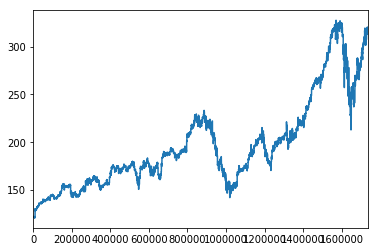

In [6]:
aapl_df['close'].plot()

Now that we have seen our data - it's time to try and predict the prices. Our currant plan in to first try differrent models, with different configurations - and then continue with the ones that we saw the best results. 


## Attempt #1 - trying to predict the direction of a stock using Random Forests

Our first attemp before we try to predict the price itself - is to try and predict the direction the price is going to. 

In [7]:
import os
import random
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')



def dir_files(dir_path):
    return [os.path.join(dir_path,f) for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]

def read_dukas(csv_path):
    df = pd.read_csv(csv_path)
    
    # rename columns
    new_cols_map = {col: col.lower() for col in df}
    new_cols_map['Local time'] = "datetime"
    df.rename(columns=new_cols_map, inplace=True)

    # convert datetime type (string to datetime)
    df['datetime'] = df['datetime'].str.replace(r"\:00\.000 GMT\+0\d00","")
    df['datetime'] = pd.to_datetime(df['datetime'], format='%d.%m.%Y %H:%M')
    
    # sort by datetime
    df.sort_values(by=['datetime'], inplace=True)
    
    # reset index, more convenient
    df.reset_index(drop=True, inplace=True)
    
    return df

def add_times(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """ split datetime column to its components (ie minute, hour, day etc...) """

    df['minute'] = df[col].dt.minute
    df['hour'] = df[col].dt.hour
    df['day'] = df[col].dt.day
    df['month'] = df[col].dt.month
    df['minute_of_day'] = df['minute'] + df['hour']*60
    df['day_of_week'] = df['datetime'].dt.dayofweek
    return df

def norm_window(df, length):
    return (df - df.rolling(length).min()) / (df.rolling(length).max() - df.rolling(length).min())

def pred_acc(target, pred):
    return (np.sign(pred) == target).sum() / len(pred)

def split_data(df, date1, date2=None):
    """ split the data into training set and test set. 
        if the date2 argument is passed, split the data into training, validation, and test sets.
        dates are string formats, in the format 'mm-dd-yyyy'.
        split will be made on the 'datetime' column (assuming passed df has one)
    """
    
    if date2==None:
        train = df[df['datetime'] < date1]
        test = df[df['datetime'] >= date1]
        return train, test
    else:
        train = df[df['datetime'] < date1]
        valid = df[(df['datetime'] >= date1) & (df['datetime'] < date2)]
        test = df[df['datetime'] >= date2]
        return train, valid, test

def print_score(target, pred):
    print(f"MSE = {mean_squared_error(target, pred)}")
    print(f"acc = {pred_acc(target, pred)}")

## 1) getting data

In [8]:
# inputs
aapl_csv_path = r'data\relevant\dukascopy\BID\AAPL.USUSD.csv'
save_dir = r'C:\Users\asaf\Desktop\DS_workshop-project\local_exp\direction_postPP_files'
AGG = 10 + 1  # minutes - 5,10,15,30

aapl_df = read_dukas(aapl_csv_path)
aapl_df.head()

,datetime,open,high,low,close,volume
0,2017-01-26 00:00:00,121.864,121.864,121.864,121.864,0.0
1,2017-01-26 00:01:00,121.864,121.864,121.864,121.864,0.0
2,2017-01-26 00:02:00,121.864,121.864,121.864,121.864,0.0
3,2017-01-26 00:03:00,121.864,121.864,121.864,121.864,0.0
4,2017-01-26 00:04:00,121.864,121.864,121.864,121.864,0.0


## 2) pre-processing

1) split datetime to different times - minute, hour etc...  
2) drop all data that is not between 16:30 - 23:00, as these are inactive trading hours.  
3) drop all data that is in saturday and sunday, as these are not trading days.  

In [9]:
# split datetime
add_times(aapl_df, 'datetime')

# drop inactive hours
mask = (aapl_df['minute_of_day'] >= (16*60+30)) & (aapl_df['minute_of_day'] <= (23*60))
aapl_df = aapl_df[mask]

# drop inactive days
mask = (aapl_df['day_of_week'] != 5) & (aapl_df['day_of_week'] != 6)
aapl_df = aapl_df[mask]

# reset index - more convenient
aapl_df.reset_index(drop=True, inplace=True)

In [10]:
aapl_df.head()

,datetime,open,high,low,close,volume,minute,hour,day,month,minute_of_day,day_of_week
0,2017-01-26 16:30:00,121.680,121.894,121.660,121.710,0.4459,30,16,26,1,990,3
1,2017-01-26 16:31:00,121.720,121.894,121.702,121.891,0.3697,31,16,26,1,991,3
2,2017-01-26 16:32:00,121.851,122.090,121.840,122.060,0.4814,32,16,26,1,992,3
3,2017-01-26 16:33:00,122.070,122.240,122.053,122.240,0.6113,33,16,26,1,993,3
4,2017-01-26 16:34:00,122.240,122.430,122.150,122.213,0.6310,34,16,26,1,994,3


as we can see, there are still inactive data points (holydays, for example).  
lets see how many 0 volume rows we have

In [11]:
1 - np.count_nonzero(aapl_df['volume']) / len(aapl_df)

0.05296172615996375

about 5%.  
lets drop every row that has volume 0, except rows that are at 23:00

In [12]:
mask = (aapl_df['volume'] != 0) | (aapl_df['minute_of_day']==23*60)
aapl_df = aapl_df[mask]

# reset index - more convenient
aapl_df.reset_index(drop=True, inplace=True)

lets see how many volume 0 now:

In [13]:
1 - np.count_nonzero(aapl_df['volume']) / len(aapl_df)

0.002372220054623453

~0.2%, much better.

In [14]:
aapl_df.head()

,datetime,open,high,low,close,volume,minute,hour,day,month,minute_of_day,day_of_week
0,2017-01-26 16:30:00,121.680,121.894,121.660,121.710,0.4459,30,16,26,1,990,3
1,2017-01-26 16:31:00,121.720,121.894,121.702,121.891,0.3697,31,16,26,1,991,3
2,2017-01-26 16:32:00,121.851,122.090,121.840,122.060,0.4814,32,16,26,1,992,3
3,2017-01-26 16:33:00,122.070,122.240,122.053,122.240,0.6113,33,16,26,1,993,3
4,2017-01-26 16:34:00,122.240,122.430,122.150,122.213,0.6310,34,16,26,1,994,3


## 3) data aggregation
aggregate data so that each data point represent __'AGG'__ minutes window of trading session.  
in other words, we make our data an __'AGG'__ minutes candles, instead of 1 minute.

In [15]:
aapl_df['high'] = aapl_df['high'].rolling(AGG).max()
aapl_df['low'] = aapl_df['low'].rolling(AGG).min()
aapl_df['open'] = aapl_df['open'].shift(AGG-1)

In [16]:
aapl_df.head(20)

,datetime,open,high,low,close,volume,minute,hour,day,month,minute_of_day,day_of_week
0,2017-01-26 16:30:00,NaN,NaN,NaN,121.710,0.4459,30,16,26,1,990,3
1,2017-01-26 16:31:00,NaN,NaN,NaN,121.891,0.3697,31,16,26,1,991,3
2,2017-01-26 16:32:00,NaN,NaN,NaN,122.060,0.4814,32,16,26,1,992,3
3,2017-01-26 16:33:00,NaN,NaN,NaN,122.240,0.6113,33,16,26,1,993,3
4,2017-01-26 16:34:00,NaN,NaN,NaN,122.213,0.6310,34,16,26,1,994,3
5,2017-01-26 16:35:00,NaN,NaN,NaN,122.042,0.5824,35,16,26,1,995,3
6,2017-01-26 16:36:00,NaN,NaN,NaN,122.221,0.5718,36,16,26,1,996,3
7,2017-01-26 16:37:00,NaN,NaN,NaN,122.240,0.4668,37,16,26,1,997,3
8,2017-01-26 16:38:00,NaN,NaN,NaN,122.230,0.5610,38,16,26,1,998,3
9,2017-01-26 16:39:00,NaN,NaN,NaN,122.211,0.4925,39,16,26,1,999,3


drop minutes that are not within aggregation step

In [17]:
mask = aapl_df['minute'] % (AGG-1) == 0
aapl_df = aapl_df[mask]

# reset index - more convenient
aapl_df.reset_index(drop=True, inplace=True)

In [18]:
aapl_df.head()

,datetime,open,high,low,close,volume,minute,hour,day,month,minute_of_day,day_of_week
0,2017-01-26 16:30:00,NaN,NaN,NaN,121.710,0.4459,30,16,26,1,990,3
1,2017-01-26 16:40:00,121.680,122.430,121.66,122.053,0.4777,40,16,26,1,1000,3
2,2017-01-26 16:50:00,122.221,122.221,121.81,122.090,0.4805,50,16,26,1,1010,3
3,2017-01-26 17:00:00,122.010,122.111,121.93,121.971,0.4826,0,17,26,1,1020,3
4,2017-01-26 17:10:00,122.029,122.112,121.90,122.064,0.3233,10,17,26,1,1030,3


## 4) more features
1) close roc 1h, 2h, 1d  
2) close std 1h, 2h, 1d  
3) target - direction of next candle

In [20]:
def rate_of_change(df, col, new_col, length):
    df[new_col] = df[col]/df[col].shift(int(length / (AGG-1)))

def standard_deviation(df, col, new_col, length):
    df[new_col] = df[col].rolling(int(length / (AGG-1))).std()
      

for length, new_col in zip([60,120,400], ['roc1h', 'roc2h', 'roc1d']):
    rate_of_change(aapl_df, 'close', new_col, length)
    
for length, new_col in zip([60,120,400], ['std1h', 'std2h', 'std1d']):
    standard_deviation(aapl_df, 'close', new_col, length)

aapl_df['target'] = aapl_df['close'].shift(-1) / aapl_df['close'] - 1
aapl_df['target'][aapl_df['target'] > 0] = 1
aapl_df['target'][aapl_df['target'] <= 0] = -1

In [23]:
aapl_df.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
datetime,2017-01-26 16:30:00,2017-01-26 16:40:00,2017-01-26 16:50:00,2017-01-26 17:00:00,2017-01-26 17:10:00,2017-01-26 17:20:00,2017-01-26 17:30:00,2017-01-26 17:40:00,2017-01-26 17:50:00,2017-01-26 18:00:00,2017-01-26 18:10:00,2017-01-26 18:20:00,2017-01-26 18:30:00,2017-01-26 18:40:00,2017-01-26 18:50:00,2017-01-26 19:00:00,2017-01-26 19:10:00,2017-01-26 19:20:00,2017-01-26 19:30:00,2017-01-26 19:40:00
open,NaN,121.68,122.221,122.01,122.029,122.044,121.919,121.7,121.84,121.85,121.821,121.69,121.7,121.713,121.77,121.91,121.822,122,121.804,121.792
high,NaN,122.43,122.221,122.111,122.112,122.114,121.932,121.852,121.893,121.903,121.883,121.758,121.773,121.844,121.922,121.91,122.002,122,121.861,121.882
low,NaN,121.66,121.81,121.93,121.9,121.85,121.64,121.68,121.712,121.77,121.6,121.62,121.62,121.67,121.76,121.8,121.64,121.79,121.78,121.77
close,121.71,122.053,122.09,121.971,122.064,121.862,121.74,121.84,121.862,121.854,121.69,121.659,121.71,121.801,121.851,121.82,121.903,121.82,121.833,121.88
volume,0.4459,0.4777,0.4805,0.4826,0.3233,0.3929,0.3124,0.3755,0.3247,0.4993,0.3525,0.4433,0.3552,0.3642,0.42,0.3173,0.4814,0.2939,0.2705,0.309
minute,30,40,50,0,10,20,30,40,50,0,10,20,30,40,50,0,10,20,30,40
hour,16,16,16,17,17,17,17,17,17,18,18,18,18,18,18,19,19,19,19,19
day,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26
month,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


## 5) normalization
squeeze OHLC into the range of 0-1, relative to the previews 10 datapoints.

In [24]:
for col in ['open','high','low','close']:
    aapl_df[col] = norm_window(aapl_df[col], 10)

finally, drop Nans

In [25]:
aapl_df.dropna(inplace=True)
aapl_df.reset_index(drop=True, inplace=True)

In [26]:
aapl_df.head().T

,0,1,2,3,4
datetime,2017-01-27 16:30:00,2017-01-27 16:40:00,2017-01-27 16:50:00,2017-01-27 17:00:00,2017-01-27 17:10:00
open,0.0983607,1,1,0.422535,1
high,1,1,0.588235,0.705882,0.829412
low,0,0.5,0,1,1
close,0.642857,1,0.84,1,0.464396
volume,0.4466,0.6504,0.5663,0.3583,0.448
minute,30,40,50,0,10
hour,16,16,16,17,17
day,27,27,27,27,27
month,1,1,1,1,1


## 6) modeling

lets focus on trying to find a single RF which do well on AAPL.  
in order to do that, lets first split data set into training, validation and test sets.  
we will split the data in a simple (maybe stupid) way -  
the training set will be from 26/1/2017 - 1/3/2019,  
the validation set will be from 1/3/2019 - 1/10/2019,  
and the test set will be from 1/10/2019 - 22/5/2020.  

we will further investigate the way we split our dataset in the future, but that will do for now.

In [27]:
train, valid, test = split_data(aapl_df, "03-01-2019", "10-01-2019")
for df in [train, valid, test]:
    df.drop(columns='datetime', inplace=True)

setup basic RF model

In [28]:
rf1 = RandomForestRegressor(n_estimators=30, n_jobs=-1, max_depth=20, random_state=1)
rf1.fit(train.drop(columns=['target']), train['target'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [29]:
print_score(valid['target'], rf1.predict(valid.drop(columns='target')))

MSE = 1.0329357014951037
acc = 0.5039508340649693


terrible results on validation set (like coin flip).  
how well is it on training set?

In [30]:
print_score(train['target'], rf1.predict(train.drop(columns='target')))

MSE = 0.3497170365814462
acc = 0.9960982658959537


overfit!  
lets try different RF

In [31]:
rf1 = RandomForestRegressor(n_estimators=30, n_jobs=-1, max_depth=10, random_state=1)
rf1.fit(train.drop(columns=['target']), train['target'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [32]:
print_score(valid['target'], rf1.predict(valid.drop(columns='target')))

MSE = 1.0098525525692055
acc = 0.5046532045654083


still bad. still overfit?

In [33]:
print_score(train['target'], rf1.predict(train.drop(columns='target')))

MSE = 0.8498289248708008
acc = 0.7913294797687861


not as much, but still overfit we believe (79% accuracy is probably just too good to be true).

lets try to automate the hyperparameters tunning.  
lets run many RFs, with different, randomly selected, hyper parameters,  
and then we will figure out if we found some interesting RF.

In [34]:
random.seed(1)
rfs = []
hps = []
scores = []
for i in range(300):
    
    # generate hyper parameters
    hp = {'max_depth': random.choice([5,7,10,15]),
          'min_samples_leaf': random.choice([3,5,10,20]), 
          "max_features": random.choice([0.3,0.5,0.7,1]), 
          'bootstrap': random.choice([True, False]),
          'oob_score': random.choice([True, False]),
          'n_estimators': random.choice([10,30,50,100]),
          'n_jobs': -1, 
          'random_state': 1}
    
    # create RF (if created HP doesnt have conflict)
    try:
        rf = RandomForestRegressor(**hp)
        rf.fit(train.drop(columns=['target']), train['target'])
    except:
        pass
    else:
        score_d = dict()
        
        # calc score on validation set
        pred = rf.predict(valid.drop(columns='target'))
        score_d['v_MSE'] = mean_squared_error(valid['target'], pred)
        score_d['v_acc'] = pred_acc(valid['target'], pred)

        # calc score on training set
        pred = rf.predict(train.drop(columns='target'))
        score_d['t_MSE'] = mean_squared_error(train['target'], pred)
        score_d['t_acc'] = pred_acc(train['target'], pred)

        # save data and RFs
        rfs.append(rf)
        hps.append(pd.DataFrame(hp, index=[0]))
        scores.append(pd.DataFrame(score_d, index=[0]))    

In [35]:
results = pd.concat([pd.concat(hps), pd.concat(scores)], axis=1).reset_index(drop=True)
results = results.drop_duplicates()
results.head()

,max_depth,min_samples_leaf,max_features,bootstrap,oob_score,n_estimators,n_jobs,random_state,v_MSE,v_acc,t_MSE,t_acc
0,7,3,0.7,True,False,100,-1,1,1.002133,0.512204,0.952899,0.654335
1,15,20,0.5,True,False,10,-1,1,1.017249,0.509219,0.841676,0.739306
2,15,20,0.3,False,False,30,-1,1,1.011542,0.500615,0.804004,0.856021
3,5,10,0.3,True,True,10,-1,1,1.002216,0.511853,0.984759,0.556792
4,15,5,1.0,True,True,100,-1,1,1.002305,0.510799,0.781930,0.940944


how many RFs were created?

In [36]:
len(results)

193

any good RF with good results on validation set?

In [37]:
results.sort_values(by=['v_acc'], ascending=False).head()

,max_depth,min_samples_leaf,max_features,bootstrap,oob_score,n_estimators,n_jobs,random_state,v_MSE,v_acc,t_MSE,t_acc
8,5,5,1.0,False,False,10,-1,1,0.999927,0.521686,0.990247,0.557081
81,15,5,1.0,False,False,100,-1,1,1.000901,0.519754,0.727742,0.969316
57,15,20,1.0,True,False,100,-1,1,1.000502,0.519052,0.905847,0.793738
170,5,10,0.5,True,True,10,-1,1,1.000904,0.518525,0.983114,0.561657
38,15,10,0.7,True,True,50,-1,1,1.009944,0.516945,0.775186,0.893690


52%!  
ok! little better...  

how good the results are in terms of MSE?

In [38]:
results.sort_values(by=['v_MSE'], ascending=True).head()

,max_depth,min_samples_leaf,max_features,bootstrap,oob_score,n_estimators,n_jobs,random_state,v_MSE,v_acc,t_MSE,t_acc
201,7,20,1.0,True,True,50,-1,1,0.998829,0.515364,0.978643,0.614306
160,7,20,1.0,True,False,50,-1,1,0.998829,0.515364,0.978643,0.614306
89,7,10,1.0,True,False,100,-1,1,0.999015,0.514838,0.975331,0.623940
65,5,3,1.0,False,False,50,-1,1,0.999061,0.512379,0.989336,0.570809
74,5,5,1.0,True,False,100,-1,1,0.999083,0.509219,0.989194,0.574855


still very bad (compare to simple 0 on each prediction -> will result MSE=1).  

how decisive are our RFs?  
could it be that predictions that are closer to 1/-1, has higher accuracy?  
maybe predictions that are closer to 0, indicate an uncertainty in the prediction?  

lets try to find an answer in the data:  
1) lets take the predicitons of our best 10 RFs.  
2) put close predictions into baskets (rounding the predictions).  
3) see wether the further the basket of predictions from 0, the better accuracy we get.

take the predictions of our 10 best RFs:

In [39]:
rfs_idx = list(results.sort_values(by=['v_acc'], ascending=False).head(10).index)
pred = []
target = []
for i in rfs_idx:
    pred.append(rfs[i].predict(valid.drop(columns='target')))
    target.append(valid['target'])

# merge the predictions and targets
pred = np.concatenate(pred)
target = np.concatenate(target)

let see the predictions values range:

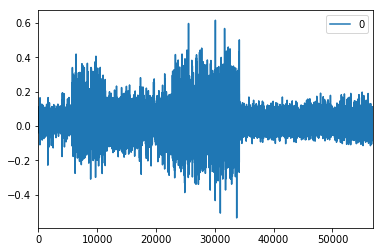

In [40]:
pd.DataFrame(pred).plot()

interesting...  
we can see that predictions ranges differently across different RFs.  

alright, we can (and should) further examine that, but for now we will leave that aside.  

coming back to our previoues question,  
lets see, in our __best RF only__, if the distance of predictions from 0 is an indication of prediction's accuracy.

taking best RF predictions

In [52]:
best_i = results.sort_values(by=['v_acc'], ascending=False).index[0]
best_rf = rfs[best_i]
pred = best_rf.predict(valid.drop(columns=['target']))
pred

array([ 0.01313705,  0.0375153 , -0.01677661, ...,  0.02346157,
        0.03333241,  0.06440518])

predictions range:

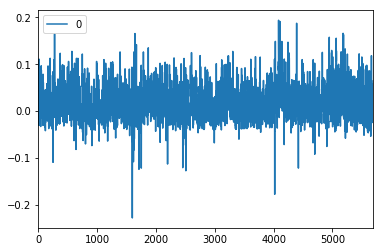

In [53]:
pd.DataFrame(pred).plot()

we can see some skew towards the positive values.  
this might come from the natural tendency of stocks (and aaple in particular) to rise over long perionds of time,  
yet this is just a speculation.

rounding predictions:

In [54]:
pred

array([ 0.01313705,  0.0375153 , -0.01677661, ...,  0.02346157,
        0.03333241,  0.06440518])

In [55]:
pred[pred>0] = np.ceil(pred[pred>0]*100)/100
pred[pred<=0] = np.floor(pred[pred<=0]*100)/100
pred

array([ 0.02,  0.04, -0.02, ...,  0.03,  0.04,  0.07])

accuarcy levels per basket of predictions:

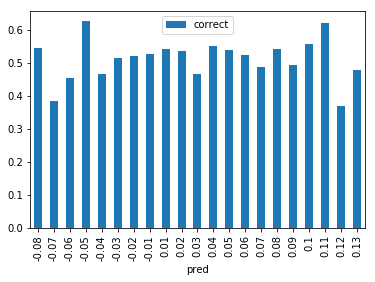

In [73]:
df = pd.DataFrame([pred, valid['target']]).T
df.columns = ['pred', 'target']

# calculate how many correct predictions
df['correct'] = np.sign(df['pred']) == np.sign(df['target'])

del df['target']

# calculate accuracy
c = df.groupby(['pred']).count()
s = df.groupby(['pred']).sum()
acc = s/c

# display baskets with at least 10 predictions in it
acc = acc[c > 10].dropna()

# plotting
acc.rename(columns={'correct':'acc'})
acc.plot.bar()

our intuition doesnt seem to hold true in the predictions of our best RF.  

## How We Go From Here

// chalenges we see coming